# Inferential Analysis on Changes in Snow Depth Due to Elevation

## Introduction

During the winter season, many people like to go hit the slopes to have some fun, and even more so in BC as the province is home to many world-renowned skiing destinations. When choosing a location, one of the main factors perceived by many that contribute to a greater skiing experience is the elevation of the mountain, as it’s believed that a higher elevation leads to an increase in snow depth which helps improve one’s skiing experience. This relationship between elevation and snow depth is a popular claim by the public, with one study suggesting a positive correlation between elevation and snow depth and another suggesting a similar proposition up to an elevation of 3300 meters (Grünewald et al., 2014; Kirchner et al., 2014). As skiing hobbyists ourselves, we wanted to set out and investigate whether this claim is statistically significant. We decided to focus on locations within BC for relevancy, and settled on comparing the snow depths captured by automated snow weather stations placed in two locations with a distinct difference in elevation: Callaghan, an area just west of Whistler with an elevation of 1017 meters, and Silver Star Mountain, home to the famous Silver Star Ski Resort elevated at 1839 meters. As such, our question will be: does the higher elevation of Silver Star Mountain have a greater snow depth than the lower elevation of Callaghan?

Our chosen location and scale parameter will be the mean and standard deviation, respectively. Finding the means of the samples allows us to carry out a one-tailed two-sample t-test which would be relevant for answering the question, while finding the standard deviations will allow us to observe the variability of the observations in each sample.

We’ll be using two datasets from the BC government containing samples of snow depth in centimeters, captured by snow weather stations located in Callaghan and Silver Star Mountain as previously stated. The datasets will be filtered down to contain observations only in the month of January 2019 for reduced variability in measurements caused by seasonal changes (Ye & Ellison, 2003).

## Preliminary Results

Loading necessary libraries:

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(gridExtra)
library(lubridate)
library(broom)
# Install the package
install.packages("infer")
# Load the package
library(infer)

#setting seed to be reproducable
set.seed(276)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



Reading the csv data files from the data folder. Each corresponding csv file from each location is loaded into a different variable.

In [2]:
## Unsure if We need Air Temp, this would be for future analysis
# air_temp_callaghan <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/Callaghan/AT.csv', col.names = c("Time", "NULL", "AirTempCelcius"))
# air_temp_silverstar <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/SilverStar/AT.csv', col.names = c("Time", "NULL", "AirTempCelcius"))
# head(air_temp_silverstar)

# air_temp_callaghan <- air_temp_callaghan %>%
#     filter(!is.na(AirTempCelcius)) %>%
#     mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
#           AirTempCelcius = as.numeric(AirTempCelcius),
#           Location = "Callaghan") %>%
#     filter(!is.na(AirTempCelcius)) |>
#     select(Time, AirTempCelcius, Location)

# air_temp_silverstar <- air_temp_silverstar %>%
#     filter(!is.na(AirTempCelcius)) %>%
#     mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
#           AirTempCelcius = as.numeric(AirTempCelcius),
#           Location = "SilverStar") %>%
#     filter(!is.na(AirTempCelcius)) |>
#     select(Time, AirTempCelcius, Location)

# head(air_temp_callaghan)

In [3]:
snow_depth_callaghan <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/Callaghan/SD.csv', col.names = c("Time", "NULL", "SnowDepth"))
snow_depth_silverstar <- read.csv(file = 'https://raw.githubusercontent.com/carlosperez67/Stat-201-Project/main/data/SilverStar/SD.csv', col.names = c("Time", "NULL", "SnowDepth"))

head(snow_depth_silverstar)

,Time,NULL.,SnowDepth
,<chr>,<chr>,<chr>
1,"GRADEDESCRIPTIONS-3=GAP, -2=UNUSABLE, -1=UNSPECIFIED, 0=UNDEF, 11=POOR, 21=ESTIMATED, 25=BEST PRACTICE, 31=GOOD, 41=VERYGOOD, 51=EXCELLENT, APPROVALDESCRIPTIONS 800=WORKING, 900=IN REVIEW, 1200=APPROVED",,
2,Timestamp (UTC),Event Timestamp (UTC),Value (cm)
3,2015-08-13 22:00:00,,0
4,2015-08-13 23:00:00,,5
5,2015-08-14 00:00:00,,-1
6,2015-08-14 01:00:00,,-4


As you can see above, we must from tidy and wrangle the data. 

In [4]:
# For Each DataSet we filter away the Null/NA values. Then we convert the charachter dates to R's built in date object type.
# Next for the snowdepth we filter away the negative snow depths (impossible/instrument error)
snow_depth_silverstar <- snow_depth_silverstar %>%
    filter(!is.na(SnowDepth)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          SnowDepth = as.numeric(SnowDepth),
          Location = "SilverStar") %>%
    filter(SnowDepth >= 0, !is.na(SnowDepth)) |>
    select(Time, SnowDepth, Location)

snow_depth_callaghan <- snow_depth_callaghan %>%
    filter(!is.na(SnowDepth)) %>%
    mutate(Time = strptime(Time, tz = "GMT", format = "%Y-%m-%d %H:%M:%S"),
          SnowDepth = as.numeric(SnowDepth),
          Location = "Callaghan") %>%
    filter(SnowDepth >= 0, !is.na(SnowDepth)) |>
    select(Time, SnowDepth, Location)

head(snow_depth_silverstar)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


,Time,SnowDepth,Location
,<dttm>,<dbl>,<chr>
1,2015-08-13 22:00:00,0,SilverStar
2,2015-08-13 23:00:00,5,SilverStar
3,2015-08-14 04:00:00,2,SilverStar
4,2015-08-14 05:00:00,3,SilverStar
5,2015-08-14 06:00:00,2,SilverStar
6,2015-08-14 07:00:00,2,SilverStar


Next lets join all these data sets together. 

In [5]:
#Adding All the SnowDepth Data together
snow_data <- rbind(snow_depth_silverstar,snow_depth_callaghan)
#head(snow_data)
#Adding All the AirTemp Data together
# temp_data <- rbind(air_temp_silverstar,air_temp_callaghan)
#head(temp_data)

#Adding all the telementary data together:
# telementary <- merge(snow_data, temp_data)
# head(telementary)



As stated in our introduction, the seasons play a desicive role in snow depth and air temperature. Therefore we will only look at data from the month of January, which is conviently in the dead of the Canadian winter.

In [6]:
jan_data <- snow_data |>
    filter(as.numeric(strftime(snow_data$Time, "%m")) == 1,
          as.numeric(strftime(snow_data$Time, "%Y")) == 2019,) 

#Adding another column to easily graph the dates on the x-axis
jan_data <- jan_data |>
    mutate(Date = as.numeric(strftime(jan_data$Time, "%d")))

## Sample Distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



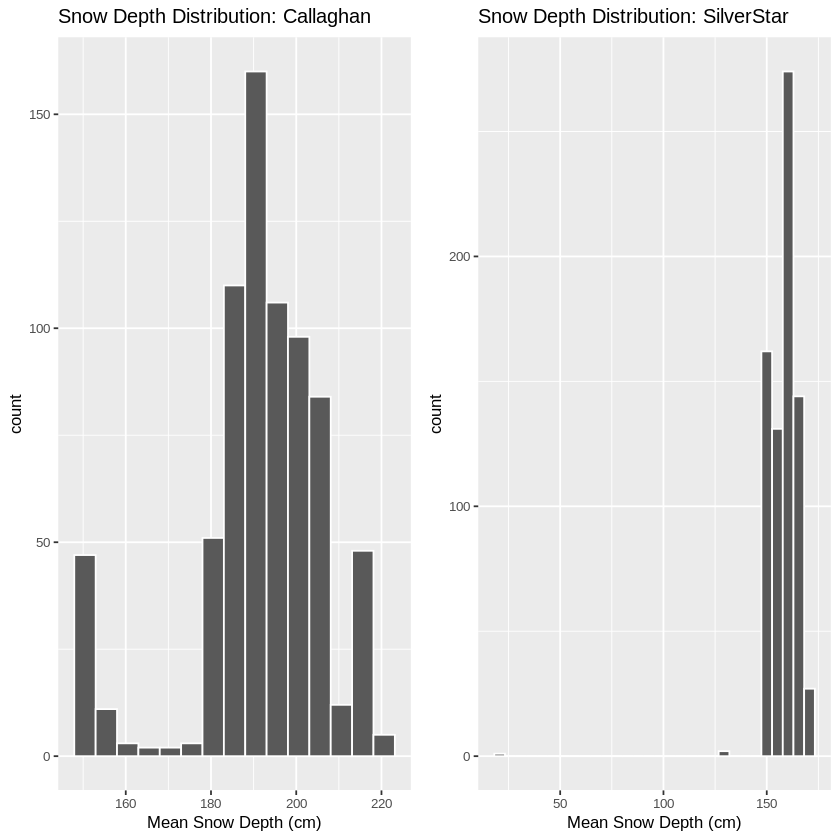

In [7]:
# Plotting Callaghan sample distribution for the month of january
call_sample_dist_plot <-
     jan_data %>% 
    filter(Location == "Callaghan") %>% 
     ggplot() +
     geom_histogram(aes(x=SnowDepth), bins = 15, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=10)) + 
     ggtitle("Snow Depth Distribution: Callaghan") 

silv_sample_dist_plot <-
     jan_data %>% 
    filter(Location == "SilverStar") %>% 
     ggplot() +
     geom_histogram(aes(x=SnowDepth), color="white") +
     xlab("Mean Snow Depth (cm)") + 
     theme(text = element_text(size=10)) + 
     ggtitle("Snow Depth Distribution: SilverStar") 

#Displaying Both Histograms Side by Side
grid.arrange(call_sample_dist_plot, silv_sample_dist_plot, ncol=2)

 Lets graph the samples of snow depth at Silver Star that we have in 2019.

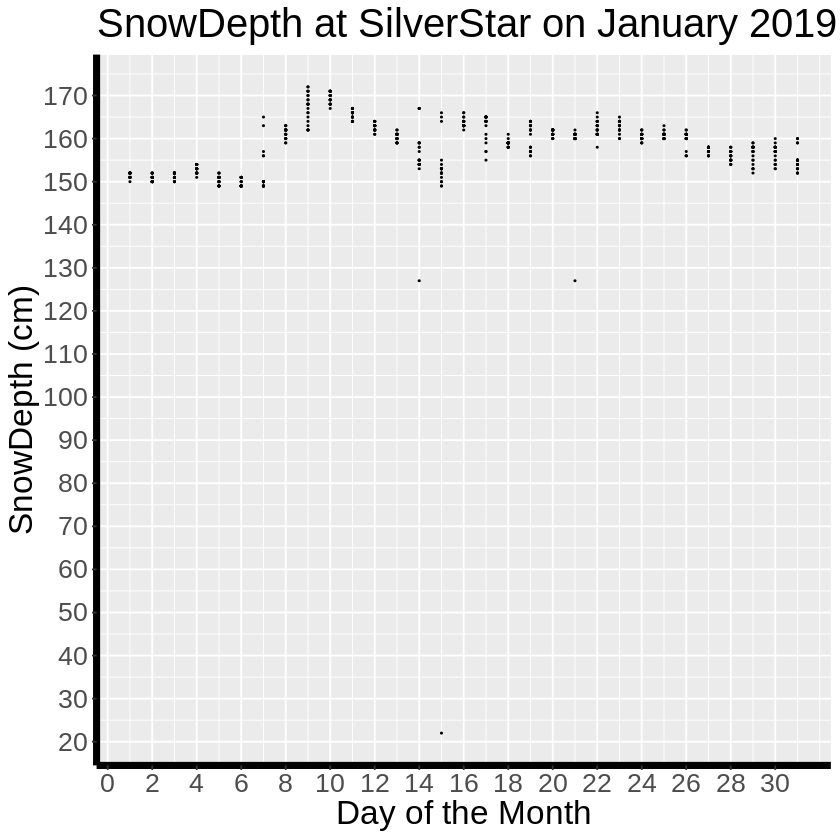

In [8]:
silverstar2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    filter(Location == "SilverStar") |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth), size = 0.2) +
    ggtitle("SnowDepth at SilverStar on January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,200,10))
silverstar2019_plot

 Lets graph the samples of snow depth at Callaghan that we have in 2019.

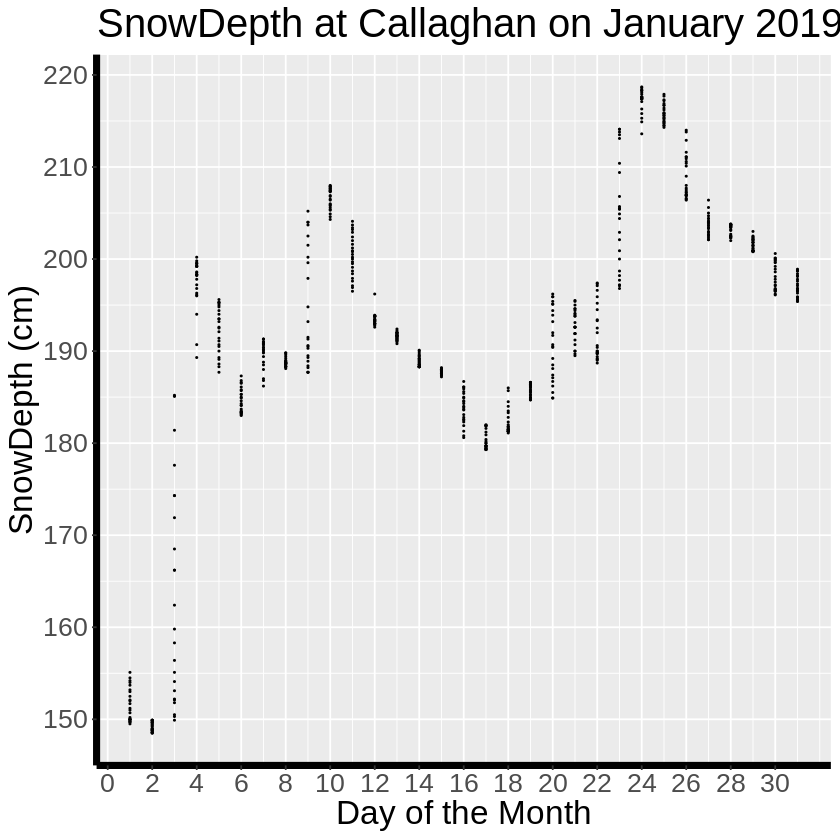

In [9]:
callaghan2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    filter(Location == "Callaghan") |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth), size = 0.2) +
    ggtitle("SnowDepth at Callaghan on January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,300,10))
callaghan2019_plot

#### Let's see all the data side by side.

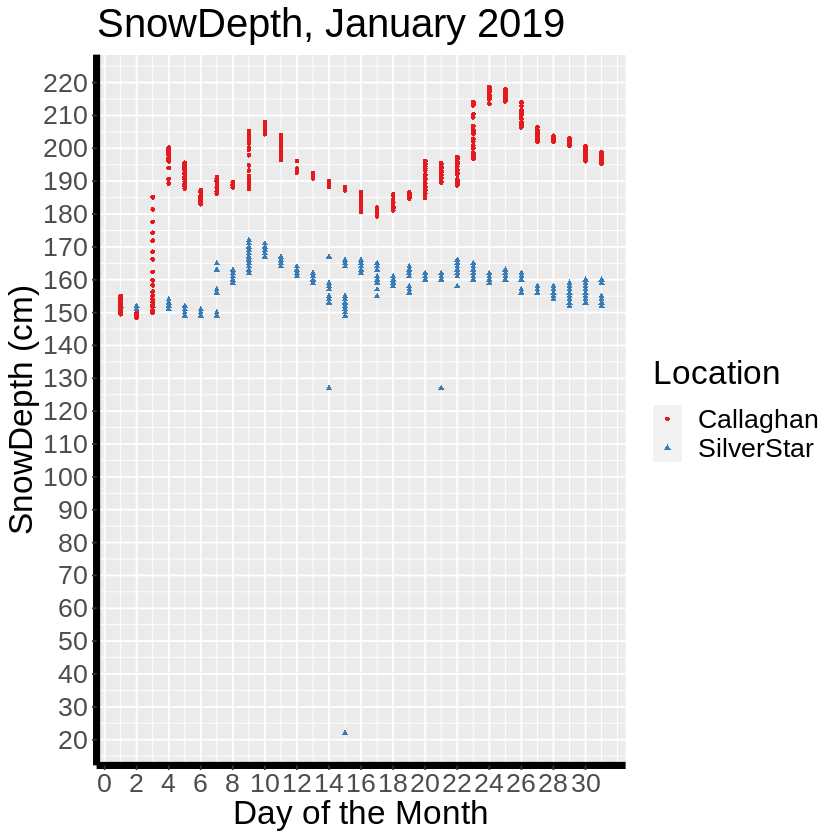

In [10]:
jan2019_plot <- jan_data |>
    select(Time, Location, SnowDepth, Date) |>
    ggplot() +
    geom_point(aes(x = Date, y = SnowDepth, color = Location, shape = Location), size = 1) +
    ggtitle("SnowDepth, January 2019") +
    xlab("Day of the Month") + 
    ylab("SnowDepth (cm)") +
    theme(text = element_text(size=20),
         axis.line = element_line(colour = "black", size = 2)) +
    scale_x_continuous(breaks=seq(0,30,2)) +
    scale_y_continuous(breaks=seq(0,300,10)) +
    scale_color_brewer(palette = "Set1")
jan2019_plot

Visually, it appears that there is a difference between the Callaghan and SilverStar snowdepths.
Let's estimate the mean snowdepth (cm) for each location for January 2019 by calculating the mean of our samples.

In [32]:
jan_2019_summary <- jan_data |>
    group_by(Location) |>
    summarize(MeanSnowDepth = mean(SnowDepth))
jan_2019_summary

jan_2019_summary <- jan_data %>%
    group_by(Location) %>%
    summarize(MeanSnowDepth = mean(SnowDepth),
              sample_var = var(SnowDepth),
              n = n())
jan_2019_summary

Location,MeanSnowDepth
<chr>,<dbl>
Callaghan,191.5876
SilverStar,158.2051


Location,MeanSnowDepth,sample_var,n
<chr>,<dbl>,<dbl>,<int>
Callaghan,191.5876,237.3462,742
SilverStar,158.2051,58.2903,741


#### Lets add this mean to the plot.

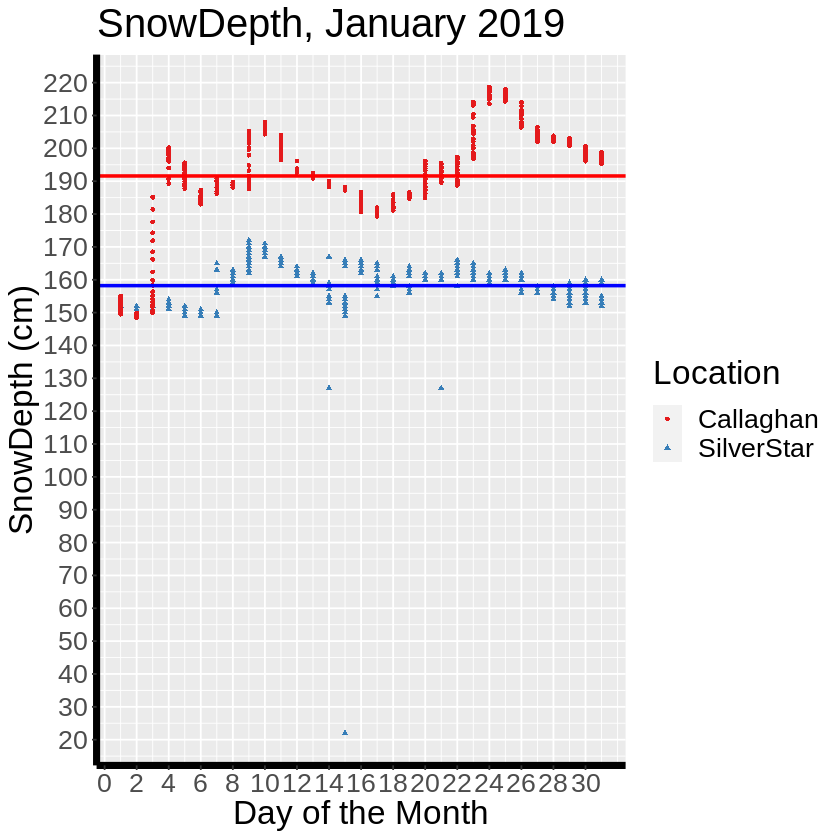

In [33]:
jan_2019_plot_summary <- jan2019_plot +
    geom_hline(yintercept = jan_2019_summary$MeanSnowDepth[1],color = "red", size= 1) +
    geom_hline(yintercept = jan_2019_summary$MeanSnowDepth[2],color = "blue", size= 1)

jan_2019_plot_summary

#### Taking 1000 Bootstrap Samples of Size 100

In [34]:
# bootstrap for snow depth for SilverStar
dist_mean_depth_silverstar <- 
     jan_data %>% 
     filter(Location == "SilverStar") %>%
     rep_sample_n(reps = 1000, size = 100, replace = TRUE) %>% 
     group_by(replicate) %>% 
     summarize(mean_silverstar = mean(SnowDepth)) %>% 
     select(mean_silverstar)

# bootstrap for snow depth for Callaghan
dist_mean_depth_callaghan <- 
     jan_data %>% 
     filter(Location == "Callaghan") %>%
     rep_sample_n(reps = 1000, size = 100, replace = TRUE) %>% 
     group_by(replicate) %>% 
     summarize(mean_callaghan = mean(SnowDepth)) %>% 
     select(mean_callaghan)

# Merging the two datasets together
bootstrap_dist_snow <- merge(dist_mean_depth_callaghan, dist_mean_depth_silverstar)

head(bootstrap_dist_snow)


,mean_callaghan,mean_silverstar
,<dbl>,<dbl>
1,195.261,158.8
2,193.251,158.8
3,191.124,158.8
4,190.530,158.8
5,193.760,158.8
6,189.315,158.8


#### Plotting Sampling Distribution

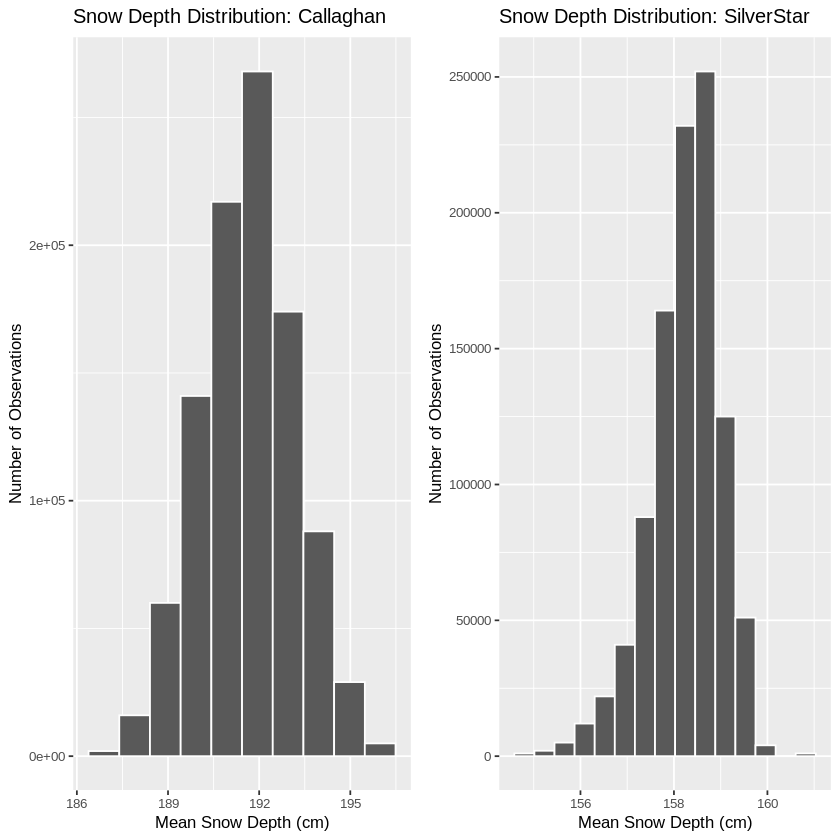

In [35]:
# Distribtuion of snow depth of SilverStar 
boot_snow_plot_silverstar <-
     bootstrap_dist_snow %>% 
     ggplot() +
     geom_histogram(aes(x = mean_silverstar), bins = 15, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     ylab("Number of Observations") +
     theme(text = element_text(size=10)) + 
     ggtitle("Snow Depth Distribution: SilverStar")

# Distribtuion of snow depth of Callaghan
boot_snow_plot_callaghan <-
     bootstrap_dist_snow %>% 
     ggplot() +
     geom_histogram(aes(x = mean_callaghan), bins = 10, color="white") +
     xlab("Mean Snow Depth (cm)") + 
     ylab("Number of Observations") +
     theme(text = element_text(size=10)) + 
     ggtitle("Snow Depth Distribution: Callaghan") 

#Displaying Both Histograms Side by Side
grid.arrange(boot_snow_plot_callaghan, boot_snow_plot_silverstar, ncol=2)

## Methods: Plan

From our preliminary results, we see that the mean snow depth for Callaghan is actually greater than Silver Star, so based on that we can expect to find that a higher elevation does not lead to greater snow depth. We’ll state the null hypothesis to be that there’s no difference between the mean snow depths of Silver Star and Callaghan and our alternate hypothesis to be that the difference between Silver Star and Callaghan snow depths is greater than zero (ie. mean snow depth of Silver Star is greater than mean snow depth of Callaghan). 

We will also calculate the confidence intervals through bootstrapping and asymptotic methods (normal distribution, CLT, t-distribution) to evaluate the accuracy of our estimates. If our expected findings are correct, then we can also expect to not reject the null hypothesis. Based on our expected findings, if higher elevation does not lead to greater snow depth, then more questions could be raised on why this is, such as the geography/location of the mountains playing a larger role in snow depth. Our expected conclusions could also help future companies/wealthy investors evaluate new locations for ski resorts, knowing whether elevation is or isn't a big factor in ensuring sufficient snow depth for a good skiing experience.


### Confidence Interval from Bootstrapping Using Percentile

In [36]:
# 90% Confidence Interval for SilverStar Using Quantile
ci_silverstar <- 
    dist_mean_depth_silverstar %>% 
    summarize(ci_lower_silverstar = quantile(mean_silverstar, 0.05),
              ci_upper_silverstar = quantile(mean_silverstar, 0.95))

# 90% Confidence Interval for Callaghan Using Quantile
ci_callaghan <- dist_mean_depth_callaghan %>%
    summarize(ci_lower_callaghan = quantile(mean_callaghan, 0.05),
              ci_upper_callaghan = quantile(mean_callaghan, 0.95))

ci90 <- merge(ci_silverstar, ci_callaghan)
ci90

ci_lower_silverstar,ci_upper_silverstar,ci_lower_callaghan,ci_upper_callaghan
<dbl>,<dbl>,<dbl>,<dbl>
156.8895,159.34,189.1373,194.1644


### Confidence Interval from Bootstrapping Using A Theory Based Approach

In [37]:
# se_callaghan <- bootstrap_dist_snow %>% 
#     summarize(SE_Callaghan = sd(mean_callaghan))
# se_silverstar <- bootstrap_dist_snow %>% 
#     summarize(SE_SilverStar = sd(mean_silverstar))


# se_snow <- merge(se_callaghan, se_silverstar)
# se_snow

# # 90% of values fall within 1.65 standard deviations of the mean so we will apply the CI formula with this in mind
# x_bar_callaghan <- jan_2019_summary$MeanSnowDepth[1]
# x_bar_silverstar <- jan_2019_summary$MeanSnowDepth[2]

# ci_callaghan_se_theory <-  jan_data %>%
#     summarize(ci_lower_silverstar = x_bar_silverstar - 1.65 * se_silverstar,
#                                     ci_upper_silverstar = x_bar_silverstar + 1.65 * se_silverstar,
#                                     ci_lower_callaghan = x_bar_callaghan - 1.65 * se_callaghan,
#                                     ci_upper_callaghan = x_bar_callaghan + 1.65 * se_callaghan)

# ci_callaghan_se_theory

In [38]:
head(jan_data)

,Time,SnowDepth,Location,Date
,<dttm>,<dbl>,<chr>,<dbl>
1,2019-01-01 00:00:00,152,SilverStar,1
2,2019-01-01 01:00:00,152,SilverStar,1
3,2019-01-01 02:00:00,152,SilverStar,1
4,2019-01-01 03:00:00,152,SilverStar,1
5,2019-01-01 04:00:00,152,SilverStar,1
6,2019-01-01 05:00:00,152,SilverStar,1


## CLT Based Confidence Interval Calculations

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



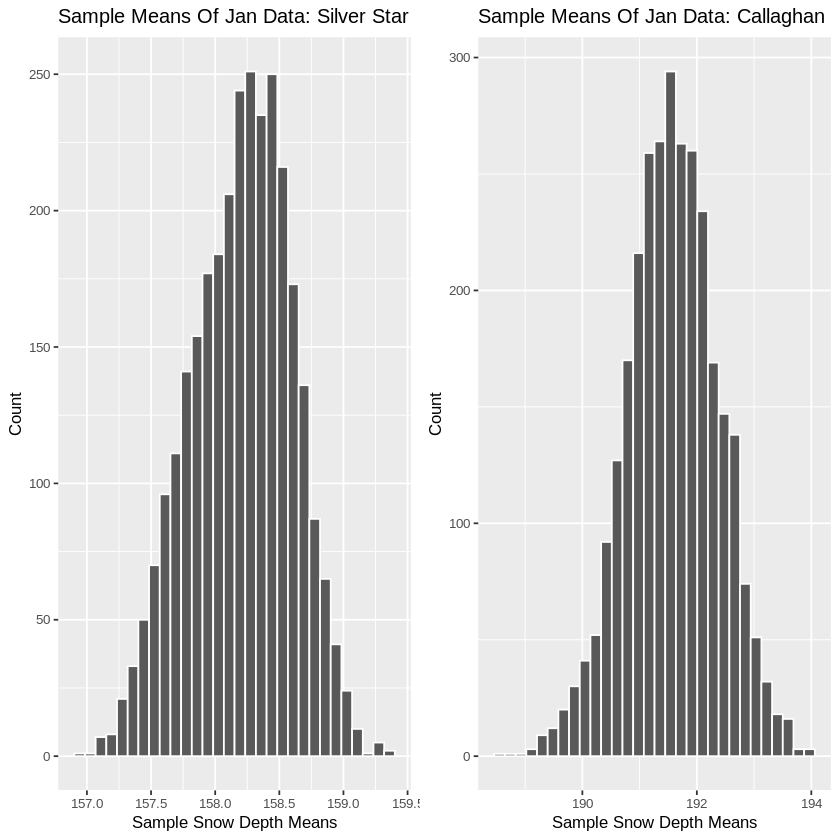

In [39]:
#Making a Sampling Distribution out of the sample. 
#(aka taking samples without replacement)

snow_samples <- jan_data |>
    rep_sample_n(size = 500, reps = 3000, replace = FALSE)

snow_samples_dist_callaghan <-
    snow_samples %>% 
    filter(Location == "Callaghan") %>%
    group_by(replicate) %>% 
    summarise(Mean_Snow_Depth = mean(SnowDepth), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = Mean_Snow_Depth), color="white") +
    theme(text = element_text(size = 10))+
    xlab("Sample Snow Depth Means") +
    ylab("Count") +
    ggtitle("Sample Means Of Jan Data: Callaghan")  

snow_samples_dist_silverstar <-
    snow_samples %>% 
    filter(Location == "SilverStar") %>%
    group_by(replicate) %>% 
    summarise(Mean_Snow_Depth = mean(SnowDepth), `.groups` = "drop") %>% 
    ggplot() + 
    geom_histogram(aes(x = Mean_Snow_Depth), color="white") +
    theme(text = element_text(size = 10))+
    xlab("Sample Snow Depth Means") +
    ylab("Count") +
    ggtitle("Sample Means Of Jan Data: Silver Star")  



grid.arrange(snow_samples_dist_silverstar, snow_samples_dist_callaghan, ncol=2)

Due to CLT, because we have a sufficienlty large sample size (n=300) and the sample size is still much smaller than our original sample (n ~ 25,000), we have estimated the sampling distribution of teh sample mean when the sample size is 300. Our sample size must be this large because the original population distribution is very asymmetric. 

##### Lets ask ourselves if CLT is applicable:
1. Is the size of your sample large enough?

Yes it is because we can observe that our populations are a decent approximation of the normal distribution. With values under n = 500 we were observing a slight slighly skewed left tail, however at n = 500 that has largly disappeared.

2. Was the sample taken in an independent fashion?

Yes because the selections or results from one sample do not impact future samples.

3. Is the estimator being used a sum of random components?

??


Since we do not know $\mu$ and $\sigma$ we can replace them with their estimates $\bar{x}$ and $s=\sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(X_i-\bar{X})^2}$

In [44]:
# Extracting Only the snow Depths from the samples created earlier
snow_samples_callaghan <- snow_samples %>%
    filter(Location == "Callaghan") %>%
    pull(SnowDepth)

snow_samples_silverstar <- snow_samples %>%
    filter(Location == "SilverStar") %>%
    pull(SnowDepth)

# Calculated Earlier
x_bar_callaghan <- jan_2019_summary$MeanSnowDepth[1]
x_bar_silverstar <- jan_2019_summary$MeanSnowDepth[2]


# Estimating standard error
s_callaghan <- sd(snow_samples_callaghan, na.rm = TRUE) / 
            sqrt(length(snow_samples_callaghan))
s_silverstar <- sd(snow_samples_silverstar, na.rm = TRUE) / 
            sqrt(length(snow_samples_silverstar))

mean_snowdepth_callaghan_ci <- 
    tibble(
        lower_ci_callaghan = qnorm(0.05, x_bar_callaghan, s_callaghan),
        upper_ci_callaghan = qnorm(0.95, x_bar_callaghan, s_callaghan),
        lower_ci_silverstar = qnorm(0.05, x_bar_silverstar, s_silverstar),
        upper_ci_silverstar = qnorm(0.95, x_bar_silverstar, s_silverstar))

mean_snowdepth_callaghan_ci

lower_ci_callaghan,upper_ci_callaghan,lower_ci_silverstar,upper_ci_silverstar
<dbl>,<dbl>,<dbl>,<dbl>
191.5584,191.6168,158.1905,158.2197


In [41]:
# However, using CLT with the normal distribution is not exactly the approach that would best approximate the confidence intervals. This is because the standard error that we created is merely an estimate/approximation. We should really be using t-distribution to find confidence intervals. So lets do that!

### Two Sample T-Test

For this hypothesis test we need to ensure that our two samples are independent. This case is true because the snow depth at Callaghan has no effect on the snow depth on SilverStar because they are far enough away that they won't experience the same weather patterns. 

We need to rely on the CLT because as seen earlier, our population is not normally distributed. This is because the CLT states that teh sampling distribution of the sample average will eventually converge into the normal distribution. 

If our sample size is large enough the T-Distribution will converge to $t_{n-1}$ under the null hypothesis.

Our Hypothesis will be: $$H_0: \mu_{\text{SilverStar}} - \mu_{\text{Callaghan}} = 0$$ $$H_1: \mu_{\text{SilverStar}} - \mu_{\text{Callaghan}} > 0$$

and we will use this test statistic:
$$
T = \frac{\bar{x}_{\text{SilverStar}} - \bar{x}_{\text{Callaghan}}}{\sqrt{\frac{s^2_{\text{SilverStar}}}{n_1}+\frac{s^2_{\text{Callaghan}}}{n_2}}}
$$

Where $\bar{x}_{\text{SilverStar}}$ and $\bar{x}_{\text{Callaghan}}$ are the sample means of snow depth for SilverStar and Callaghan mountains, respectively; $s^2_{\text{SilverStar}}$ and $s^2_{\text{Callaghan}}$ are the sample variances for the SilverStar and Callaghan mountains, respectively; and $n_1$ and $n_2$ are the sample size for SilverStar and Adelie mountains, respectively. 

In [43]:
# Here R does all the heavy lifting for us, in terms of calculating the test
# statistic and calculating the p-value
t_test <-
    tidy(
        t.test(x = filter(jan_data, Location == "SilverStar")$SnowDepth,
               y = filter(jan_data, Location == "Callaghan")$SnowDepth,
               alternative = "greater")) 

#greater because alternate hypothesis is that higher elevation results in more snow depth


t_test


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-33.38247,158.2051,191.5876,-52.87906,1,1084.59,-34.42175,Inf,Welch Two Sample t-test,greater


## References

Grünewald, T., Bühler, Y., & Lehning, M. (2014). Elevation dependency of mountain snow depth. The Cryosphere, 8(6), 2381–2394. https://doi.org/10.5194/tc-8-2381-2014

Kirchner, P. B., Bales, R. C., Molotch, N. P., Flanagan, J., & Guo, Q. (2014). LiDAR measurement of seasonal snow accumulation along an elevation gradient in the southern Sierra Nevada, California. Hydrology and Earth System Sciences, 18(10), 4261–4275. https://doi.org/10.5194/hess-18-4261-2014

Ye, H., & Ellison, M. (2003). Changes in transitional snowfall season length in northern Eurasia: TRANSITIONAL SNOWFALL SEASON. Geophysical Research Letters, 30(5), n/a-n/a. https://doi.org/10.1029/2003GL016873


### Data Sources

Government of British Columbia. (2022) Callagan Telementary. https://aqrt.nrs.gov.bc.ca/Data/Location/Summary/Location/3A20P/Interval/Latest

Government of British Columbia. (2022) Silver Star Mountain  Telementary. https://aqrt.nrs.gov.bc.ca/Data/Location/Summary/Location/2F10P/Interval/Latest